# GxSex joint 2df analysis for UHS GWAS of HIV acquisition
**Author**: Jesse Marks

See [issue #97](https://github.com/RTIInternational/bioinformatics/issues/97)


Data were downloaded from S3 at:
`s3://rti-hiv/uhs_data`

These data were downloaded to EC2 at:
`/shared/data/studies/uhs1-3/`

The working directory for this 2 degree of freedom GWAS will be:
`/shared/jmarks/hiv/uhs1-3`

**Auto-scaling tags**
Cfncluster automatically creates an autoscaling group for you. To add a tag to the pre-existing auto-scaling groups, you can use the “Auto-scaling” AWS console. This is found on the AWS console left sidebar. On that page you should select the auto-scaling group for your cluster. I believe these are the ones that contain the keywords `jmarks`. For each one, select the “Tags” tab and there will be an option to add a tag. This information was derived from an email sent by Bryan Quach with the subject title being `AWS charges`.

In [ ]:
# extend EBS volume
aws ec2 modify-volume --dry-run --volume-id vol-0c6f35ae300a46947 --size 1700

# extend file system to the new volume capacity.
sudo resize2fs /dev/xvdb

# Prepare Files for ProbABEL

## Phenotype data
The phenotype data were processed by Fang. The PCs selected for the AA cohort were PC2, PC6, PC5, & PC9.
You can find the details for the data processing [here](https://github.com/RTIInternational/ffang_notebooks/blob/master/uhs_gwas_hiv.ipynb).

`head pheno_hiv_aa_probabel`
```
iid     hiv     gender  age     pc2     pc6     pc5     pc9
109@1064714572_109@1064714572   0       1       26      0.0033  0.0027  0.0027  -0.0012
202@1064714531_202@1064714531   0       0       27      0.0004  -0.0107 -0.0026 0.0079
312@1064714548_312@1064714548   0       1       34      -0.0014 -0.0083 -0.0028 -0.0033
```

Note the subject IDs are of the form famID_indivID per the MIS output.


In [ ]:
# EC2 #
cd /shared/jmarks/hiv/uhs1-3/association_tests/001

## Genotype data
### Inflate Imputation Results
The zip files from Michigan Imputation Server (MIS) need to be inflated before you can begin working with them. They require a passcode that is sent by MIS to email. The password was found in [Fang's notebook](https://github.com/RTIInternational/ffang_notebooks/blob/master/uhs_gwas_hiv.ipynb).

In [ ]:
### EC2 console ###
cd /shared/data/studies/uhs1-3/aa

# inflate chr results
for f in {1..22};do
echo '#!/bin/bash' > chr_$f.sh
echo '' >> chr_$f.sh
echo 'unzip -P "jYdXsUKB55Gcag" chr_'$f'.zip' >> chr_$f.sh
done

# might want to adjust nslots to more or less
for chr in {1..22}; do
    sh /shared/bioinformatics/software/scripts/qsub_job.sh \
    --job_name inflate_chr${chr} \
    --script_prefix chr${chr}_inflation \
    --mem 15 \
    --priority 0 \
    --nslots 5 \
    --program bash chr_${chr}.sh
done

mv *gz unencrypted
# note that I am deleting the zip files from Michigan Imputation Server because
# these data are already saved to S3
rm
rm *.sh

### Convert VCF files to MaCH format
The ProbABEL software requires the data to be in a format that is different than the VCF format that is the output from MIS. Specifically, we need to convert the VCF files to MaCH format.

In [ ]:
### EC2 ###
cd /shared/data/studies/uhs1-3/aa/unencrypted

for chr in {1..22};do
mkdir -p /shared/data/studies/uhs1-3/aa/unencrypted/mach/chr$chr
done

imputedir=/shared/data/studies/uhs1-3/aa/imputed
# Convert dosage file to mldose format
for ethnicity in aa; do
    for chr in {1..22}; do
        /shared/bioinformatics/software/scripts/qsub_job.sh \
            --job_name chr${chr}_dosage_convert \
            --script_prefix $imputedir/mach/chr$chr.mach \
            --mem 10 \
            --nslots 4 \
            --buffer 10000 \
            --priority 0 \
            --program /shared/bioinformatics/software/third_party/dosage_converter_v1.0.4/bin/DosageConvertor \
                --vcfDose ${imputedir}/chr$chr.dose.vcf.gz \
                --info ${imputedir}/chr$chr.info \
                --prefix ${imputedir}/mach/chr$chr/chr$chr.mach \
                --type mach \
                --format 1  # contains the expected alternate allele count (one value per sample per marker).
    done
done

* To get an idea of the range for the run time of DosageConvertor I list here the quickest and longest run times chromosomes 2 and 21, respectively.

```
==> chr21.mach.qsub.log <==
 ------------------------------------------------------------------------------
                                END OF PROGRAM
 ------------------------------------------------------------------------------

 Program Successfully Implemented...

 Total Run completed in 1 hours, 53 mins, 27 seconds.

 Thank You for using DosageConvertor !!!


==> chr2.mach.qsub.log <==
 ------------------------------------------------------------------------------
                                END OF PROGRAM
 ------------------------------------------------------------------------------

 Program Successfully Implemented...

 Total Run completed in 11 hours, 18 mins, 14 seconds.

 Thank You for using DosageConvertor !!!

```

# Start ProbABEL Analysis
Perform  2 degree-freedom GWAS (GxSex)
See the [manual](http://www.genabel.org/sites/default/files/pdfs/ProbABEL_manual.pdf) for more information.

## Prepare directory structure and files

In [ ]:
/shared/data/studies/uhs1-3/aa/imputed/mach
mkdir -p /shared/bioinformatics/jmarks/hiv/uhs1-3/association_tests/001/aa/{final,processing}
imputeDir=/shared/data/studies/uhs1-3/aa/imputed/mach
phenoDir=/shared/data/studies/uhs1-3/aa/phenotype/pheno_hiv_aa_probabel


for i in {1..22}; do
    mkdir -p $imputeDir/chr${i}/mldose_files
done

# prepare info files (only 7 fields allowed)
for chr in {1..22}; do
    cut -f 1-7 ${imputeDir}/chr${chr}/chr${chr}.mach.mach.info > ${imputeDir}/chr${chr}/mldose_files/chr${chr}.final.info &
done



### Reorder and prune mach.dose files down to subjects in phenotype file
Note, the following is a bash script

Following instructions from the [ProbABEL manual](http://www.genabel.org/sites/default/files/pdfs/ProbABEL_manual.pdf) on page 7 in section 3.2 - *Genomic predictor file*.

The order of SNPs in the SNP information file and DOSE  file must be the same. The total number and the order of the IDs in the phenotype file should be exactly the same as in the genomic predictor (DOSE) file. 


**Note**: The dosage files (imputed data) may contain data on more subjects than is in the phenotype file. For this reason, we have to prune the dosage files down to only the subjects contained in the phenotype file. If, however, the phenotype file and the dosage files contained exactly the same subjects then it would make more sense to reorder the phenotype file rather than reordering the dosage files because the dosage files are much larger.

In [ ]:
processingDir=/shared/data/studies/uhs1-3/aa/imputed/mach

mkdir $processingDir/file_prep

# first, get the order of the IDs in the mldose_file
# use chr22 because it is the smallest
zcat $processingDir/chr22*gz | cut -f1 > $processingDir/dose.IDs.all &
tail -n +2 /shared/data/studies/uhs1-3/aa/phenotype/pheno_hiv_aa_probabel | cut -f 1 > $processingDir/file_prep/phen.IDs.all

#-------------------------------------------------------------------------------- 
awk ' NR==FNR{ map[FNR]=$1} {gsub(/^.+->/, NR"->", $1) ' $processingDir/file_prep/phen.IDs.all $processingDir/file_prep/dose.IDs.all > test


#-------------------------------------------------------------------------------- 



## start bash script titled `mldose_ordering.sh`
-------------------------------------------------------------------------------
#!/bin/bash

zcat $1/chr$2/chr$2.mach.mach.dose.gz | grep -f id_order > chr$2/ordered_mach.dose

# manual says that probabel expects a sequential id followed by an arrow followed by study ID
awk '{gsub(/^.+->/, NR"->", $1); print $0}'  chr$2/mldose_files/ordered_mach.dose > chr$2/mldose_files/chr$2.final.dose
rm chr$2/ordered_mach.dose


#!/bin/bash

zcat $1/chr$3.mach.mach.dose.gz | awk '{gsub(/^.+->/, NR"->", $1); print $0}' > $1/mldose_files/chr$3.final.dose



## END bash script
--------------------------------------------------------------------------------

# get id_order from pheno file
tail -n +2 ${phenoDir} | cut -d ' ' -f 1 > id_order

imputeDir=/shared/data/studies/uhs1-3/aa/imputed/mach
# submit as jobs
for chr in {1..22};do
    /shared/bioinformatics/software/scripts/qsub_job.sh \
            --job_name mldose_chr${chr}_prep \
            --script_prefix chr${chr}/mldose.ordering \
            --mem 8 \
            --nslots 3 \
            --program bash prep_mldose.sh $imputeDir ${chr}
done




#### had to alter the dose file
The dosage files contained one extra subject that was not included in the phenotype data. Therefore, we have to perform the following command to exclude this subject.

In [ ]:
cd /shared/data/studies/uhs1-3/aa/imputed/mach

# python script
#--------------------------------------------------------------------------------
### This script prunes the imputed data (dosage files) based on subject IDs
### being present or not in the phenotype file
### sample run:
### python test.script.py 22
### 
### note that the chr number is required as an argument

import gzip,sys
chr = sys.argv[1]

BASE_DIR = "/shared/data/studies/uhs1-3/aa/imputed/mach/"

doseFile = gzip.open(BASE_DIR + 'chr' + chr +  '/chr' + chr + '.mach.mach.dose.gz')

phenFile = open(BASE_DIR + 'phen.IDs.all', 'r')
phenLines = phenFile.read().splitlines()

outF = file(BASE_DIR + 'chr' + chr + '/mldose_files/' + 'chr' + chr + '.final.dose', 'w')

count = 1
for line in doseFile:
    inF = line.split()
    tmpID = inF[0].split("->")[0]
    if (tmpID in phenLines):
        inF[0] = str(count) + "->" + tmpID
        outF.write("\t".join(inF) + "\n")
        count = count + 1
#--------------------------------------------------------------------------------
processingDir=/shared/data/studies/uhs1-3/aa/imputed/mach

for chr in {1..22}; do
    /shared/bioinformatics/software/scripts/qsub_job.sh \
                --job_name alter_dose_chr$chr \
                --script_prefix $processingDir/chr${chr}/mldose.ordering \
                --mem 8 \
                --nslots 5 \
                --program python mldose.file.prep.py $chr
done





## delete subject on line 756 because they are missing in the phenotype file
#
#sed '756d' *dose > chr15.final.dose.filtered
#
## note do this for all of the dose files
#
#for chr in {1..22}; do
#    sed '756d' chr$chr/mldose_files/*dose > chr$chr/mldose_files/chr$chr.final.dose.filtered
#done &
#
#processingDir=/shared/data/studies/uhs1-3/aa/imputed/mach
#for chr in {1..14};do
#    /shared/bioinformatics/software/scripts/qsub_job.sh \
#            --job_name alter_dose_chr$chr \
#            --script_prefix $processingDir/chr${chr}/mldose.delete.line \
#            --mem 8 \
#            --nslots 3 \
#            --program bash alter.dose.sh $processingDir ${chr}
#done
#    
#processingDir=/shared/data/studies/uhs1-3/aa/imputed/mach
#for chr in {16..22};do
#    /shared/bioinformatics/software/scripts/qsub_job.sh \
#            --job_name alter_dose_chr$chr \
#            --script_prefix $processingDir/chr${chr}/mldose.delete.line \
#            --mem 8 \
#            --nslots 3 \
#            --program bash alter.dose.sh $processingDir ${chr}
#done




### Create legend


Pg. 10 of the [ProbABEL](http://www.genabel.org/sites/default/files/pdfs/ProbABEL_manual.pdf) manual reports that the legend should be in HapMap format:

`rsID, position, allele1, allele2`

Note: We do not have the rsID right now. We have the chromosome and the position. It shouldn't be to difficult to convert this to the actual rsID. We might be able to use Nathan Gladdis' Nyholt script to convert these. This can be converted later, though. Also, this is an optional file. The only column that is actually used is the SNP location.

In [ ]:
## EC2 console ##
cd /shared/data/studies/uhs1-3/aa/imputed/mach

# HapMap "legend" file format
# note that our markerIDs are not in rsID format - we have chr:position for the rsID instead
for chr in {1..22}; do
    # grab the position, allele1 and allele2
    awk '{gsub(/^.+:/, "", $1); print $1,$2,$3}' chr${chr}/mldose_files/*.info > chr${chr}/position_and_alleles.txt
    # grab the SNP ID, which is chr:position
    cut -f 1 chr${chr}/mldose_files/*.info > chr${chr}/snp_ids.txt
    # combine the columns
    paste -d " "  chr${chr}/snp_ids.txt chr${chr}/position_and_alleles.txt > chr${chr}/map.chr${chr}.legend
    # rename the header
    sed '1 s/.*/id position 0 1/' chr${chr}/map.chr${chr}.legend > chr${chr}/mldose_files/chr$chr.final.legend 
    
    rm chr${chr}/{*.txt,*legend}
done &

## Perform 2-df GWAS 
**Note:** Because performing the GWAS is so memory intensive, we updated the compute node fleet to r4.8xlarge because they have 244G of memory and 32 CPU. After this analysis is finished, revert to a smaller (less expensive) set of compute nodes.

In [ ]:
## EC2 console ##
cd /shared/bioinformatics/jmarks/hiv/uhs1-3/association_tests/001

baseDir=/shared/bioinformatics/jmarks/hiv/uhs1-3/association_tests/001/aa/processing
imputeDir=/shared/data/studies/uhs1-3/aa/imputed/mach
phenoDir=/shared/data/studies/uhs1-3/aa/phenotype

# note the interaction 1 corresponds to the second covariate (gender)
# note that I set the nslots so that each job occupies the entire node.
for chr in {22..1}; do
    /shared/bioinformatics/software/scripts/qsub_job.sh \
            --job_name probabel_gwas_chr${chr} \
            --script_prefix $baseDir/chr${chr}/chr${chr}_gwas \
            --mem 200 \
            --nslots 17 \
            --program /shared/bioinformatics/software/third_party/probabel-0.5.0/bin/palinear \
                --pheno $phenoDir/pheno_hiv_aa_probabel \
                --dose $imputeDir/chr${chr}/mldose_files/chr${chr}.final.dose \
                --info $imputeDir/chr${chr}/mldose_files/chr${chr}.final.info \
                --map $imputeDir/chr$chr/mldose_files/chr${chr}.final.legend \
                --interaction 1 \
                --chrom ${chr} \
                --out $baseDir/chr${chr}/chr${chr}_results
done

# Post ProbABEL Processing
## Calculate chi, p, and OR 
First, we test chr15

In [ ]:
## EC2 console ##
cd /shared/bioinformatics/jmarks/hiv/uhs1-3/association_tests/001/aa/processing/chr15

base_dir=/shared/bioinformatics/jmarks/hiv/uhs1-3/association_tests/001/aa/processing
for chr in {10..1}; do
    /shared/bioinformatics/software/scripts/qsub_job.sh \
            --job_name uhs123_chr${chr} \
            --script_prefix ${base_dir}/chr${chr}/uhs123_aa.1000G.chr$chr.stats \
            --mem 5 \
            --nslots 4 \
            --program Rscript ${base_dir}/calculate_2df_stats_from_probabel_results.R \
                --in ${base_dir}/chr${chr}/chr${chr}_results_add.out.txt \
                --out ${base_dir}/chr${chr}/uhs123_aa.1000G.chr$chr.stats \
                --interaction_covar gender
done

name A1 A2 Freq1 MAF Quality Rsq n Mean_predictor_allele chrom position beta_SNP_addA1 sebeta_SNP_addA1 beta_SNP_gender sebeta_SNP_gender cov_SNP_int_SNP_gender chi2_SNP_add

#### calc.stats script
Note, I had to add `A1`  to the end of `beta_SNP_add`. Check with the 1df calc stats rscript to see if this is consistent.

In [ ]:
fileIn <- "chr22_results_add.out.txt"
interactionCovar <- "gender"
fileOut<- "chr22.interactive.test"

In [ ]:
#!/share/apps/R/bin/Rscript

args <- commandArgs(TRUE)

loop = TRUE
while (loop) {
        if (args[1] == "--in") {
                fileIn = args[2]
        }

        if (args[1] == "--out") {
                fileOut = args[2]
        }

        if (args[1] == "--interaction_covar") {
                interactionCovar = args[2]
        }

        if (length(args)>1) {
                args<-args[2:length(args)]
        } else {
                loop = FALSE
        }
}

cat("Reading ", fileIn, "...\n", sep="")
dataTable = read.table(fileIn, header = TRUE, na.strings = c("nan","NA", "NaN"))
cat("Calculating...\n")
dataTable = dataTable[complete.cases(dataTable$beta_SNP_add),]
for (i in 1:nrow(dataTable)) {
        beta = c(dataTable[i,"beta_SNP_addA1"],dataTable[i,paste("beta_SNP_",interactionCovar,sep="")])
        sigm = matrix(c(dataTable[i,"sebeta_SNP_addA1"]^2,dataTable[i,paste("cov_SNP_int_SNP_",interactionCovar,sep="")],dataTable[i,paste("cov_SNP_int_SNP_",interactionCovar,sep="")],dataTable[i,paste("sebeta_SNP_",interactionCovar,sep="")]^2),2,2)
  sigmSolved = try(solve(sigm),silent=TRUE)

  if (is.matrix(sigmSolved)) {
                dataTable[i,"chi_2df"] = t(beta) %*% sigmSolved %*% beta
                dataTable[i,"p_2df"] = 1 - pchisq(dataTable[i,"chi_2df"],2)
  } else {
                dataTable[i,"chi_2df"] = NA
                dataTable[i,"p_2df"] = NA
        }
}
dataTable = dataTable[complete.cases(dataTable$p_2df),]

if ("chrom" %in% colnames(dataTable) & "position" %in% colnames(dataTable)) {
        dataTable = cbind(subset(dataTable,select=c(name,chrom,position)),subset(dataTable,select=-c(name,chrom,position)))
} else if ("chrom" %in% colnames(dataTable)) {
        dataTable = cbind(subset(dataTable,select=c(name,chrom)),subset(dataTable,select=-c(name,chrom)))
} else if ("position" %in% colnames(dataTable)) {
        dataTable = cbind(subset(dataTable,select=c(name,position)),subset(dataTable,select=-c(name,position)))
}

cat("Writing ", fileOut, "...\n", sep="")
write.table(dataTable, file = fileOut, row.names = FALSE, quote=FALSE)

cat("Done\n")

Note that when calculating the `stats` files, there will be few variants than in the original GWAS results. This is because the when calculating the stats those variants that had NULL calculations are filtered out during the stats-calculation step. Example:

```
wc -l chr15_results_add.out.txt
1404177 chr15_results_add.out.txt

wc -l uhs123_aa.1000G.chr15.stats
1388805 uhs123_aa.1000G.chr15.stats
```

## Convert SNP ID from chr:position to rsID

My results do not have an rsID. I need to convert my IDs - which are of the form chr:position - to rsID. We will do this by using the position information of the variants.

Note: In some cases, there will be multiple variants at a single position. This happens if the variant is not biallelic. In this case, they will likely be filtered out because of MAF<0.01 anyways.

In [ ]:
cd /shared/bioinformatics/jmarks/hiv/uhs1-3/association_tests/001/aa/processing

processingDir=/shared/bioinformatics/jmarks/hiv/uhs1-3/association_tests/001/aa/processing

ancestry=aa
for ((chr=1; chr<23; chr++)); do
    echo "Processing chr${chr}_${ancestry}"
    awk 'NR==FNR { a[$2]=$1; next } $3 in a { $1 = a[$3]; print $0 }'\
        <(zcat /shared/data/ref_panels/1000G/2013.12/impute2/ALL/ALL.chr${chr}.integrated_phase1_v3.20101123.snps_indels_svs.genotypes.nomono.unique_ids.legend.gz)\
         $processingDir/chr${chr}/uhs123_${ancestry}.1000G.chr$chr.stats >\
        $processingDir/chr${chr}/uhs123_${ancestry}.1000G.chr$chr.rsID.stats
done &

Note that there are fewer variants after converting to rsID. This is because we are using the reference panels as a way to convert our variants to their rsID based on the chromosome and position. If the variant is not in the reference panel then it will not ultimately end up in the final conversion file.

## Filter by MAF

Filter any variant whose MAF <= 0.01 in both subjects and 1000G population.

Note that this is filtering the variants down to just SNPs because the definition of a SNP is a variant that occurs at a specific genomic location and occurs to some appreciable degree (e.g. 1%).

In [ ]:
## EC2 console ##
cd /shared/bioinformatics/jmarks/hiv/uhs1-3/association_tests/001/aa/processing

processingDir=/shared/bioinformatics/jmarks/hiv/uhs1-3/association_tests/001/aa/processing

# Filter MAF <= 0.01 in subjects
#for ancestry in ea aa; do
ancestry=aa
    for ((chr=1; chr<23; chr++));do
        echo "Processing chr${chr}_${ancestry}"
        head -n 1 chr$chr/uhs123_${ancestry}.1000G.chr$chr.rsID.stats > \
            chr$chr/uhs123_${ancestry}.1000G.chr$chr.rsID.subject_maf_gt_0.01.stats

        # note column 7 corresponds to the MAF column
        awk ' NR>=2 {if ($7 >= 0.01) {print $0}}' \
            chr$chr/uhs123_${ancestry}.1000G.chr$chr.rsID.stats \
            >> chr$chr/uhs123_${ancestry}.1000G.chr$chr.rsID.subject_maf_gt_0.01.stats
    done &
#done



# Filter MAF <= 0.01 in 1000G population

# creating a list of SNPs based off of 1000G population 
# - filter the variants to ones whose MAF <= 1%
group=afr
for chr in {1..22};do
   awk ' { if ($11 >= 0.01) {print $1}}' <(zcat /shared/data/ref_panels/1000G/2013.12/impute2/ALL/ALL.chr$chr.integrated_phase1_v3.20101123.snps_indels_svs.genotypes.nomono.unique_ids.legend.gz) >\
    /shared/data/ref_panels/1000G/2013.12/impute2/ALL/ALL.chr${chr}.integrated_phase1_v3.20101123.snps_indels_svs.genotypes.nomono.unique_ids.maf_gt_0.01_${group}
done &



ancestry=aa
base_dir=/shared/bioinformatics/jmarks/hiv/uhs1-3/association_tests/001/aa/processing
#for ancestry in ea aa; do
    if [ $ancestry == "aa" ]; then
        group=afr
    elif [ $ancestry == "ea" ]; then
        group=eur
    fi
    for ((chr=1; chr<23; chr++)); do
        idList=/shared/data/ref_panels/1000G/2013.12/impute2/ALL/ALL.chr${chr}.integrated_phase1_v3.20101123.snps_indels_svs.genotypes.nomono.unique_ids.maf_gt_0.01_${group} 
        echo "Processing chr${chr}_${ancestry}"      
        /shared/bioinformatics/software/perl/utilities/extract_rows.pl \
            --source $base_dir/chr$chr/uhs123_${ancestry}.1000G.chr$chr.rsID.subject_maf_gt_0.01.stats \
            --id_list $idList \
            --out $base_dir/chr$chr/uhs123_${ancestry}.1000G.chr$chr.rsID.subject+1000G_maf_gt_0.01.stats \
            --header 1 \
            --id_column 0 
    done &
done

Note that some more of the variants were filtered due to the 1000G population MAF filter (MAF>1%)
```
wc -l chr15/uhs123_aa.1000G.chr15.rsID.subject_maf_gt_0.01.stats
434221 chr15/uhs123_aa.1000G.chr15.rsID.subject_maf_gt_0.01.stats 

wc -l chr15/uhs123_aa.1000G.chr15.rsID.subject+1000G_maf_gt_0.01.stats
408796 uhs123_aa.1000G.chr15.rsID.subject+1000G_maf_gt_0.01.stats
```

## Imputation quality filter (R-squared filterd)
Filter any variant whose $R^2<0.30$.

In [ ]:
## EC2 console ##
baseDir=/shared/bioinformatics/jmarks/hiv/uhs1-3/association_tests/001/aa

#for ancestry in ea aa; do
ancestry=aa
    for ((chr=1; chr<23; chr++));do
        echo "Processing chr${chr}_${ancestry}"
        head -n 1 $baseDir/processing/uhs123_${ancestry}.1000G.chr$chr.rsID.subject+1000G_maf_gt_0.01.stats > $baseDir/final/uhs123_${ancestry}.1000G.chr$chr.rsID.subject+1000G_MAF.RSQ 

        awk ' NR>=2 {if ($9 >= 0.30) {print $0}}' \
            $baseDir/processing/uhs123_${ancestry}.1000G.chr$chr.rsID.subject+1000G_maf_gt_0.01.stats \
            >> $baseDir/final/uhs123_${ancestry}.1000G.chr$chr.rsID.subject+1000G_MAF.RSQ
    done
done

More variants were filtered based on there imputation quality. Example:
```
wc -l uhs123_aa.1000G.chr15.rsID.subject+1000G_MAF.RSQ
402936 uhs123_aa.1000G.chr15.rsID.subject+1000G_MAF.RSQ
```

Note, should upload these results to S3 at this point.

In [ ]:
# create a README to upload to s3


baseDir=/shared/bioinformatics/jmarks/hiv/uhs1-3/association_tests/001/aa/final

aws s3 sync $baseDir s3://rti-hiv/uhs123_2df_hiv_acquisition/results --quiet &

## Generate Plots

In [ ]:
## EC2 console ##
cd /shared/bioinformatics/jmarks/hiv/uhs1-3/association_tests/001/aa

baseDir=/shared/bioinformatics/jmarks/hiv/uhs1-3/association_tests/001/aa

#for ancestry in ea aa; do
ancestry=aa
    outFile=$baseDir/processing/uhs1-3.$ancestry.1000G.GxSex.subject+1000G_MAF.RSQ.table  

    echo -e "VARIANT_id\tCHR\tPOSITION\tP\tTYPE" > $outFile

    for ((chr=1; chr<23; chr++)); do
       inFile=$baseDir/final/uhs123_$ancestry.1000G.chr$chr.rsID.subject+1000G_MAF.RSQ

        echo Processing $inFile

        tail -n +2 $inFile |\
        # notice the skipping of 13 columns until I get to the 2df_pval
        perl -lne '/^(\S+)\s+(\S+)\s+(\S+)\s+(\S+)\s+(\S+)(?:\s+\S+){13}\s+(\S+)/;
                      if (($4 eq "A" || $4 eq "C" || $4 eq "G" || $4 eq "T") && ($5 eq "A" || $5 eq "C" || $5 eq "G" || $5 eq "T")) {
                        print join("\t",$1,$2,$3,$6,"snp");
                      } else {
                        print join("\t",$1,$2,$3,$6,"indel");
                      }' >> $outFile
    done &


### With 2df calculation for lambda
ancestry=aa
baseDir=/shared/bioinformatics/jmarks/hiv/uhs1-3/association_tests/001/aa/test
sh /shared/bioinformatics/software/scripts/qsub_job.sh \
        --job_name uhs1-3.plots.2df \
        --script_prefix $baseDir/uhs123.plots.2df \
        --mem 30 \
        --priority 0 \
        --nslots 3 \
        --program Rscript /shared/bioinformatics/software/R/generate_gwas_plots.R \
            --in $baseDir/../final/uhs1-3.$ancestry.1000G.GxSex.subject+1000G_MAF.RSQ.table \
            --in_chromosomes autosomal_nonPAR \
            --in_header \
            --out $baseDir/uhs123_aa.1000G.rsID.subject+1000G_MAF.RSQ.2df.association_plots \
            --col_id VARIANT_id \
            --col_chromosome CHR \
            --col_position POSITION \
            --col_p P \
            --col_variant_type TYPE \
            --generate_snp_indel_manhattan_plot \
            --manhattan_odd_chr_color red \
            --manhattan_even_chr_color blue \
            --manhattan_points_cex 1.5 \
            --generate_snp_indel_qq_plot \
            --qq_lines \
            --qq_points_bg black \
            --qq_lambda \
            --ch2_df 2

### Without 2df calculation for lambda (1df used)
#ancestry=aa
#baseDir=/shared/bioinformatics/jmarks/hiv/uhs1-3/association_tests/001/aa/test
#sh /shared/bioinformatics/software/scripts/qsub_job.sh \
#        --job_name uhs1-3.plots.1df \
#        --script_prefix $baseDir/uhs123.plots.1df \
#        --mem 30 \
#        --priority 0 \
#        --nslots 3 \
#        --program Rscript /shared/bioinformatics/software/R/generate_gwas_plots.R \
#            --in $baseDir/../final/uhs1-3.$ancestry.1000G.GxSex.subject+1000G_MAF.RSQ.table \
#            --in_chromosomes autosomal_nonPAR \
#            --in_header \
#            --out $baseDir/uhs123_aa.1000G.rsID.subject+1000G_MAF.RSQ.1df.association_plots \
#            --col_id VARIANT_id \
#            --col_chromosome CHR \
#            --col_position POSITION \
#            --col_p P \
#            --col_variant_type TYPE \
#            --generate_snp_indel_manhattan_plot \
#            --manhattan_odd_chr_color red \
#            --manhattan_even_chr_color blue \
#            --manhattan_points_cex 1.5 \
#            --generate_snp_indel_qq_plot \
#            --qq_lines \
#            --qq_points_bg black \
#            --qq_lambda 

## View Q-Q and Manhattan Plots

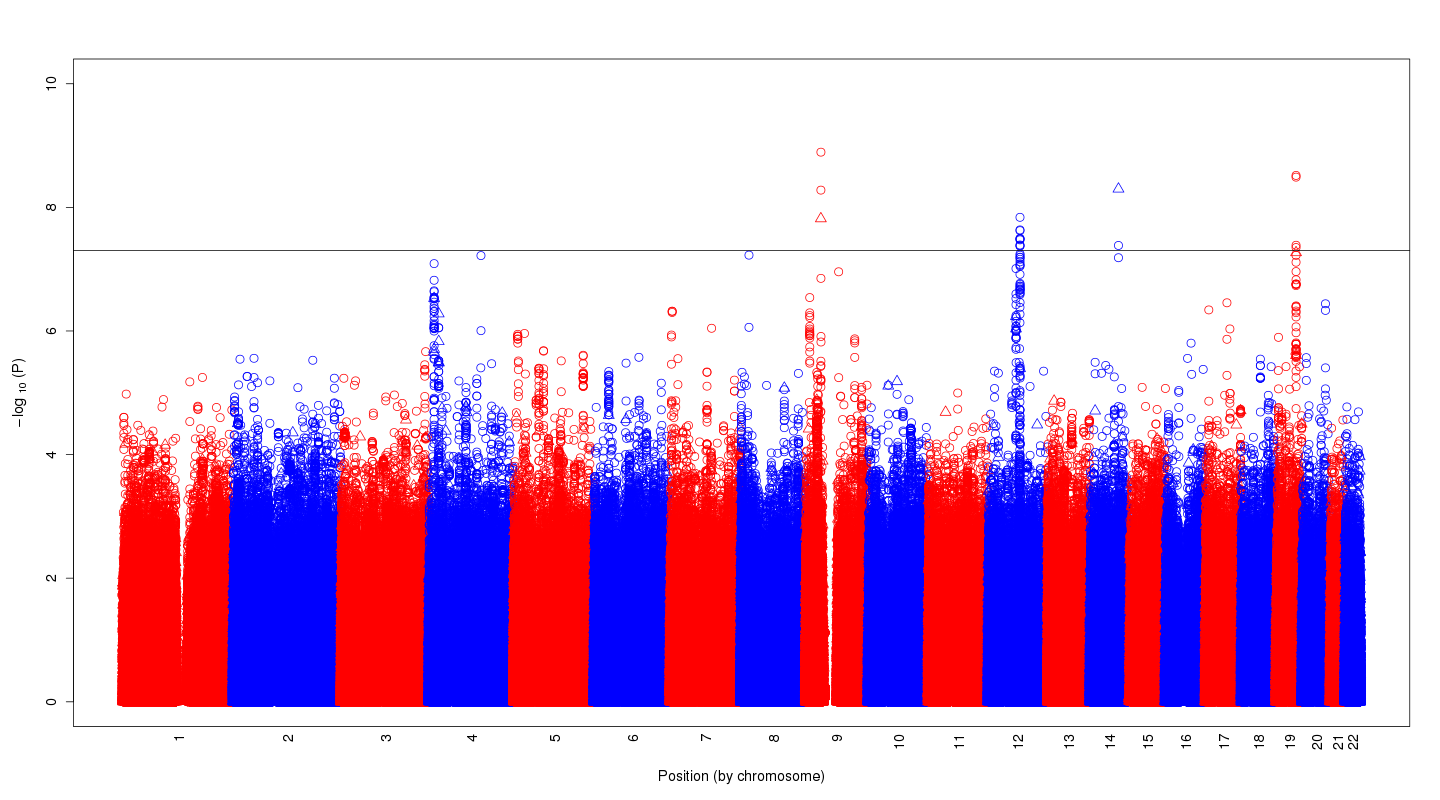

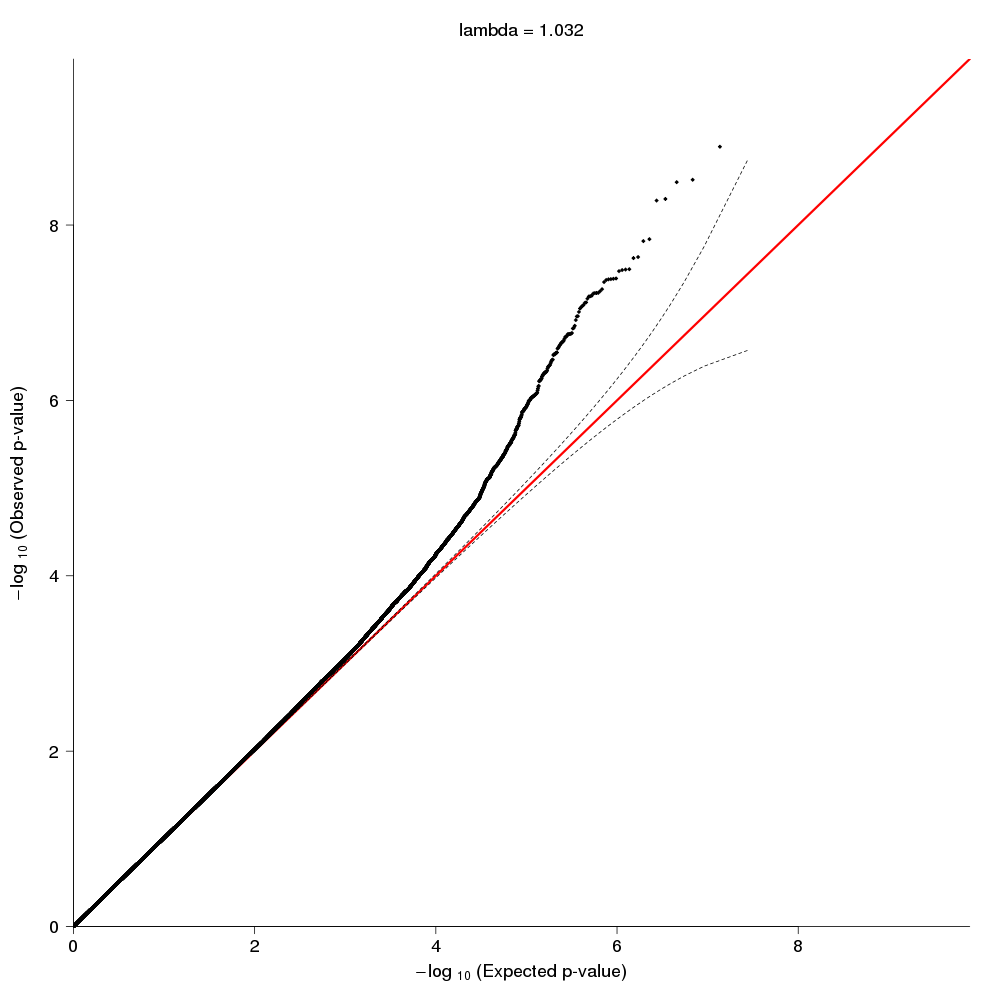

In [1]:
library("IRdisplay")
display_png(file="C:/Users/jmarks/Desktop/Projects//HIV//uhs123//aa//uhs123_aa.1000G.rsID.subject+1000G_MAF.RSQ.association_plots.snps+indels.manhattan.png")  
display_png(file="C:/Users/jmarks/Desktop/Projects//HIV//uhs123//aa//uhs123_aa.1000G.rsID.subject+1000G_MAF.RSQ.association_plots.snps+indels.qq.png")  

## Filter to top SNPs
P< 0.001

In [ ]:
### START Filter by p-value ###

#for ancestry in aa; do
#  if [ $ancestry == "aa" ]; then
#    group=afr
#  else
#    group=eur
#  fi
  #for ext in $group ${group}+$COHORT.rsq_gt_0.3; do
baseDir=/shared/bioinformatics/jmarks/hiv/uhs1-3/association_tests/001/aa/final
ancestry=aa

outFile=$baseDir/uhs123.$ancestry.1000G.GxSex.subject+1000G_MAF.RSQ.p_lte_0.001
head -n 1 $baseDir/uhs123_aa.1000G.chr22.rsID.subject+1000G_MAF.RSQ > $outFile
    for (( chr=1; chr<23; chr++ )); do
        echo Processing $baseDir/uhs123_aa.1000G.chr$chr.rsID.subject+1000G_MAF.RSQ
        tail -n +2 $baseDir/uhs123_aa.1000G.chr$chr.rsID.subject+1000G_MAF.RSQ |
        perl -lane 'if ($F[18] <= 0.001) { print; }' >>  $outFile
done

# Sort in R
#for (ancestry in c("ea","aa")){
for (ancestry in c("aa")){
    cohort="uhs123"
    if (ancestry == "aa") { group = "afr" } else if (ancestry == "ea") { group = "eur" }
        dat=read.table(paste0('/shared/bioinformatics/jmarks/hiv/uhs1-3/association_tests/001/aa/final',
                      '/uhs123.aa.1000G.GxSex.subject+1000G_MAF.RSQ.p_lte_0.001'), header = TRUE)
        dat <- dat[order(dat$p_2df),]
        write.csv(dat,
                  file=paste0('/shared/bioinformatics/jmarks/hiv/uhs1-3/association_tests/001/aa/final',
                  '/uhs123.aa.1000G.GxSex.subject+1000G_MAF.RSQ.p_lte_0.001.csv'),
                  row.names = FALSE, quote=F)
    }


#        dat=read.table(paste0('/share/nas04/jmarks/gwas/', cohort,'/association_tests/001/',
#                      ancestry,'/processing/', cohort, '.',ancestry,
#                      '.1000G_p3.CAT_FTND~SNP+AGE+SEX+GOLD+EVs.maf_gt_0.01_',group,
#                      '+', cohort, '.rsq_gt_0.3.p_lte_0.001'), header=TRUE)
#        dat = dat[order(dat$p),]
#        write.csv(dat,
#  file = paste0('/share/nas04/jmarks/gwas/', cohort, '/association_tests/001/',
#         ancestry,'/final/', cohort, '.', ancestry, '.1000G_p3.CAT_FTND~SNP+AGE+SEX+GOLD+EVs.maf_gt_0.01_',
#                         group,'+',cohort,'.rsq_gt_0.3.p_lte_0.001.csv'), row.names = FALSE)
}

## END Filter by p-value ###

# Perform stratification calculation
See [GitHub issue 97](https://github.com/RTIInternational/bioinformatics/issues/97).

# Upload results to AWS S3
These data were uploaded to:

`s3://rti-hiv/uhs123_2df_hiv_acquisition/`